# Package Imports

In [1]:
# Data Processing
import importlib


from project_code import processing_functions as pf, visualization_functions as vf
importlib.reload(pf) 

from datetime import datetime as dt
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from statsmodels.tsa.seasonal import STL


import warnings
warnings.filterwarnings("ignore")

# Data Acquisition 

Our data is sourced through Open-Meteo's Historical Weather API.

## Selections for Data Download 

**General Details:**

- Data Source: https://open-meteo.com/en/docs/historical-weather-api

- API Call: https://archive-api.open-meteo.com/v1/era5?latitude=43.70011&longitude=-79.4163&start_date=1984-01-01&end_date=2023-12-31&hourly=temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,cloud_cover,wind_speed_10m,sunshine_duration&timezone=America%2FNew_York

https://archive-api.open-meteo.com/v1/era5?latitude=43.70011&longitude=-79.4163&start_date=1984-01-01&end_date=2023-12-31&hourly=temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,cloud_cover,wind_speed_10m,sunshine_duration,shortwave_radiation&timezone=America%2FNew_York

Per the documentation, we specify era5 in the API call, in order to ensure data consistency and to prevent unintentional alterations that may have arised from the adoption of different weather model upgrades. 


**Toronto Details:**

- Latitude: 43.70011  
- Longitude: -79.4163  
- Timezone: America/New_York  
- Start Date: 1984-01-01  
- End Date: 2023-12-31  

We will primarily focus our analyses on data between 1994 and 2023; however, we are downloading an additional decade's worth, in case it becomes necessary. 


Although Daily Weather Variables are available for selection, we opt for Hourly Variables instead, so that we can include Cloud Cover information in our analyses. 


**Hourly Weather Variables:**
- Temperature (2 m)
- Relative Humidity (2 m)
- Dew Point (2 m)
- Precipitation (rain + snow)
- Cloud Cover Total
- Wind Speed (10 m)

**Additional Variables:**
- Sunshine Duration

**Solar Radiation Variables:**
- Shortwave Solar Radition GHI

Although this variable will not be used in the experiments, we download it to assess the strength of its relationship to sunshine duration. 

**Settings:**

- Temperature Unit: Celsius  
- Wind Speed Unit: Km/h  
- Precipitation Unit: Millimeter  
- Timeformat: ISO 8601 (e.g. 2022-12-31)  


In [2]:
# Download data from Open Meteo
file_path = '../../data/raw_data/'
file_name = 'era5_data_toronto.json'
# api_call = 'https://archive-api.open-meteo.com/v1/era5?latitude=43.70011&longitude=-79.4163&start_date=1984-01-01&end_date=2023-12-31&hourly=temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,cloud_cover,wind_speed_10m,sunshine_duration,shortwave_radiation&timezone=America%2FNew_York'
# pf.download_data(api_call, file_path, file_name)

In [3]:
# read in data 
file = f'{file_path}{file_name}'
weather_data = pf.df_from_json(file)
weather_data.name = 'weather_data'

pf.generate_df_summary(weather_data)

Dataframe: weather_data

------ Head: ------


,time,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,cloud_cover,wind_speed_10m,sunshine_duration,shortwave_radiation
0,1984-01-01T00:00,-9.3,75,-13.0,0.0,100,8.0,0.0,0.0
1,1984-01-01T01:00,-9.6,76,-13.0,0.0,85,7.6,0.0,0.0
2,1984-01-01T02:00,-10.1,77,-13.3,0.0,60,6.6,0.0,0.0
3,1984-01-01T03:00,-9.9,79,-12.8,0.0,51,6.0,0.0,0.0
4,1984-01-01T04:00,-10.8,81,-13.4,0.0,32,6.0,0.0,0.0




------ Tail: ------


,time,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,cloud_cover,wind_speed_10m,sunshine_duration,shortwave_radiation
350635,2023-12-31T19:00,0.4,82,-2.3,0.1,100,12.7,0.0,0.0
350636,2023-12-31T20:00,0.3,84,-2.1,0.3,100,11.9,0.0,0.0
350637,2023-12-31T21:00,0.2,88,-1.5,0.5,100,13.6,0.0,0.0
350638,2023-12-31T22:00,0.2,89,-1.5,0.4,100,13.0,0.0,0.0
350639,2023-12-31T23:00,0.1,89,-1.5,0.3,100,13.2,0.0,0.0




------ Column Summaries: ------


,count,unique,top,freq
time,350640,350640,1984-01-01T00:00,1


,count,mean,std,min,25%,50%,75%,max
temperature_2m,350640.0,8.385759,10.559070,-27.1,0.4,8.4,17.4,34.2
relative_humidity_2m,350640.0,71.907723,14.841568,18.0,61.0,73.0,84.0,100.0
dew_point_2m,350640.0,3.302916,10.535977,-31.7,-4.1,3.6,12.2,24.9
precipitation,350640.0,0.092773,0.395930,0.0,0.0,0.0,0.0,19.4
cloud_cover,350640.0,49.286633,38.425978,0.0,11.0,43.0,90.0,100.0
wind_speed_10m,350640.0,13.569120,6.646731,0.0,8.6,12.6,17.7,50.8
sunshine_duration,350640.0,1238.381057,1649.720954,0.0,0.0,0.0,3600.0,3600.0
shortwave_radiation,350640.0,162.148574,239.368387,0.0,0.0,7.0,271.0,1008.0




------ Counts: ------

Rows: 350,640
Columns: 9
Duplicate Rows = 0 | % of Total Rows = 0.0%


------ Info: ------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350640 entries, 0 to 350639
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   time                  350640 non-null  object 
 1   temperature_2m        350640 non-null  float64
 2   relative_humidity_2m  350640 non-null  int64  
 3   dew_point_2m          350640 non-null  float64
 4   precipitation         350640 non-null  float64
 5   cloud_cover           350640 non-null  int64  
 6   wind_speed_10m        350640 non-null  float64
 7   sunshine_duration     350640 non-null  float64
 8   shortwave_radiation   350640 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 24.1+ MB


None



------ Missing Data Percentage: ------


time                    0.0
temperature_2m          0.0
relative_humidity_2m    0.0
dew_point_2m            0.0
precipitation           0.0
cloud_cover             0.0
wind_speed_10m          0.0
sunshine_duration       0.0
shortwave_radiation     0.0
dtype: float64

There is no missing data, nor do there appear to be any immediately obvious outliers. However, we will formally assess the latter later. 

In [12]:
# rename columns 
mapper = {
    'temperature_2m' : 'temp',
    'relative_humidity_2m' : 'humidity',
    'dew_point_2m' : 'dew_point',
    'precipitation': 'precipitation',
    'cloud_cover' : 'cloud_cover',
    'wind_speed_10m' : 'wind_speed',
    'sunshine_duration' : 'sunshine_s'
}

weather_data.rename(columns=mapper, inplace=True)
weather_data['time'] = pd.to_datetime(weather_data['time'])
df_daily = pf.daily_aggregations(weather_data)

# subset to only include data from 1995
df_daily_subset = df_daily['1995':]
df_daily_subset['temp_range'] = df_daily_subset['max_temp'] - df_daily_subset['min_temp']

print(f'The aggregated daily dataset has {df_daily_subset.shape[0]} rows and {df_daily_subset.shape[1]} columns.')

The aggregated daily dataset has 10592 rows and 19 columns.


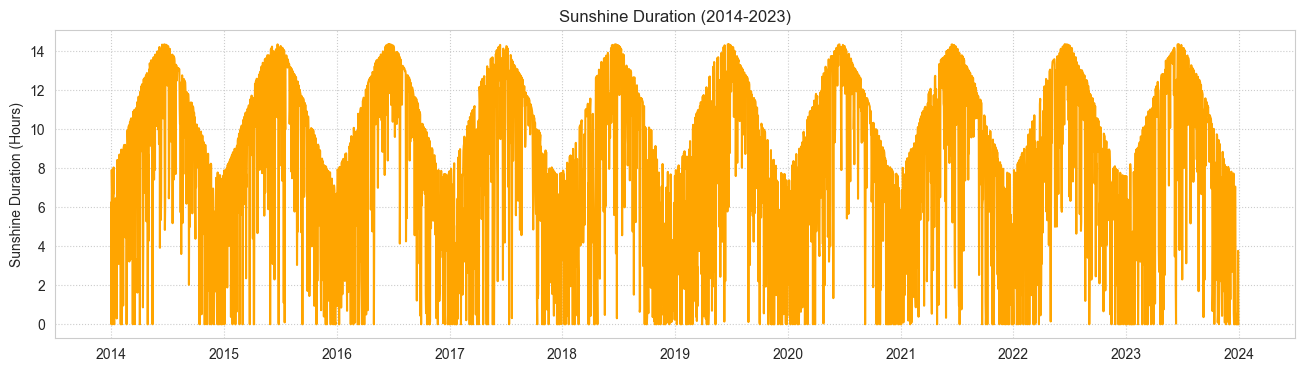

In [22]:
# plot a smaller subset of the data
sns.set_style("whitegrid", {'grid.linestyle': ':'})
plt.figure(figsize=(16, 4))
sns.lineplot(df_daily.loc['2014':'2023', 'sunshine_hr'], color='orange')
plt.title('Sunshine Duration (2014-2023)')
plt.xlabel('')
plt.ylabel('Sunshine Duration (Hours)')
plt.show()


We can see that Sunshine Duration exhibits a clear annual seasonal pattern. 

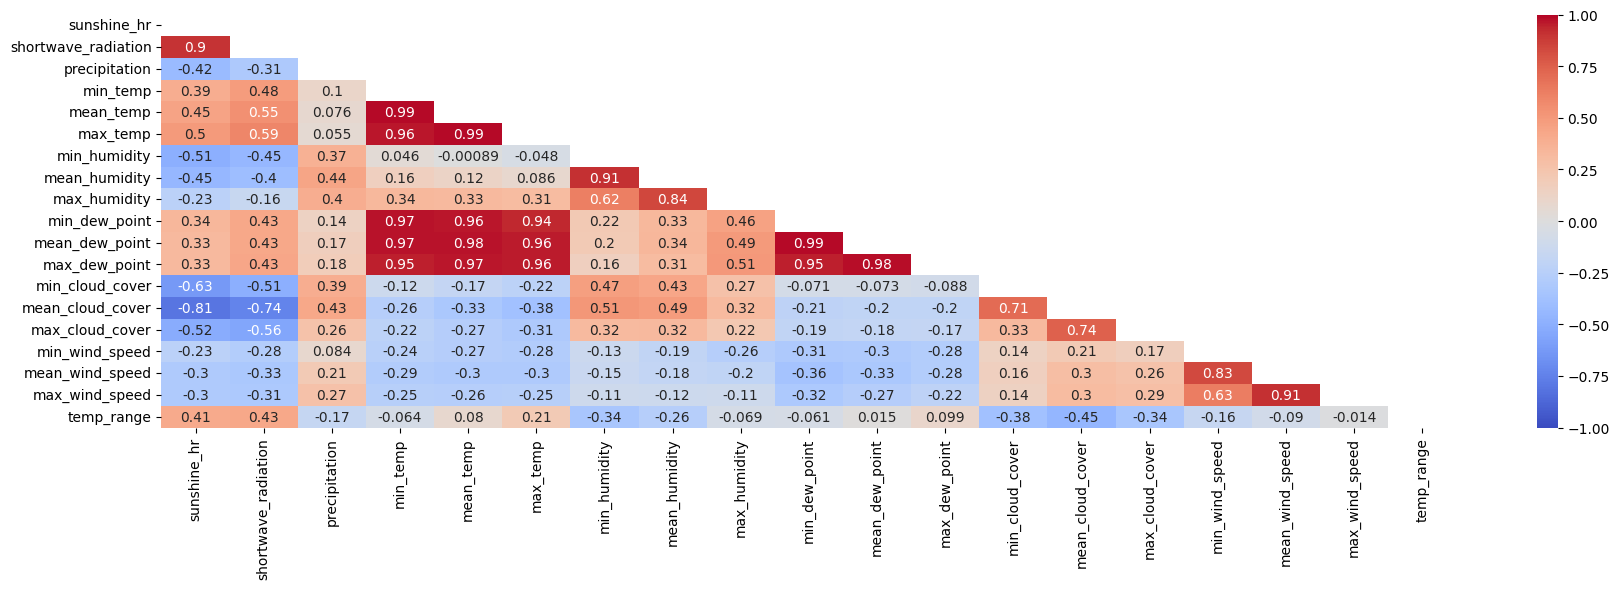

In [6]:
vf.correlation_matrix(df_daily_subset, name='correlation_all')

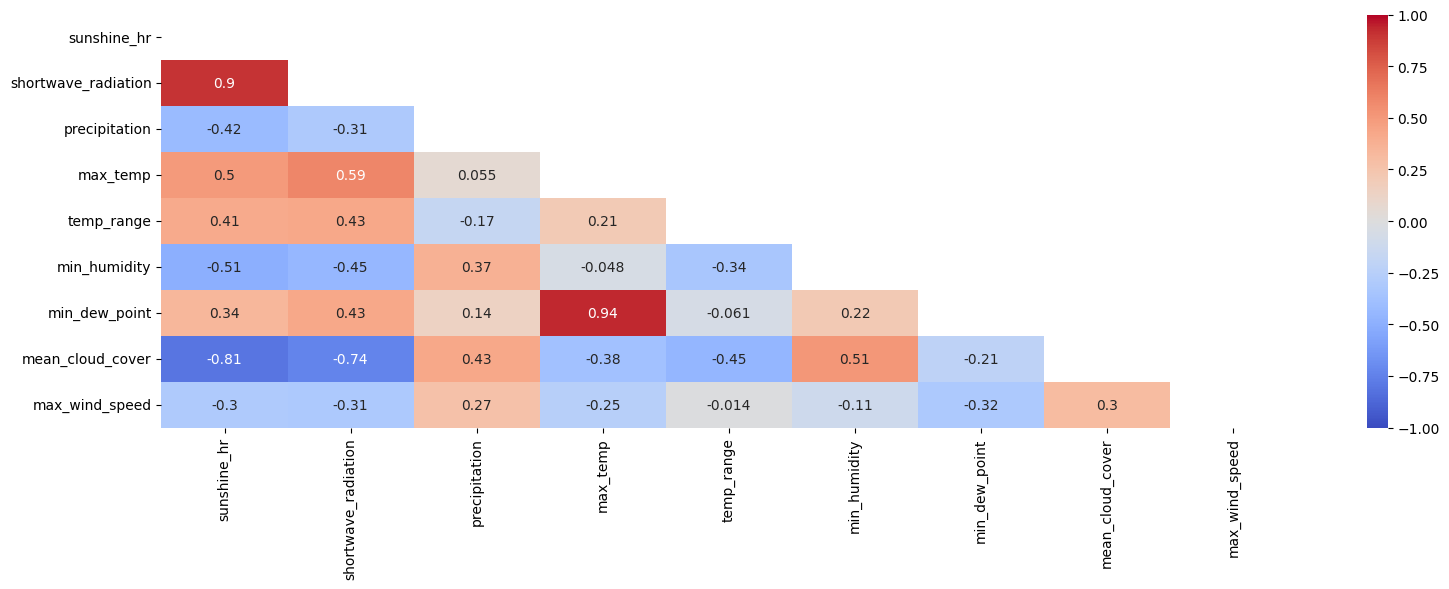

In [14]:
# a pared down correlation matrix plot based on the strongest variables within categories
top_corr_columns = ['sunshine_hr', 'shortwave_radiation', 'precipitation','max_temp', 'temp_range', 
                    'min_humidity', 'min_dew_point', 'mean_cloud_cover', 'max_wind_speed']

df_daily_subset = df_daily_subset.loc[:, top_corr_columns]

vf.correlation_matrix(df_daily_subset, figsize=(16,6), name='correlation_matrix_subset')

As expected, we can see that there is a very strong positive correlation (+0.9) between shortwave radiation and sunshine duration. There is also a very strong positive correlation between the maximum temperature and the minimum dew point (0.94), so we will drop one of the two in order to avoid potential issues related to mulicollinearity. Because maximum temperature is more strongly correlated with sunshine duration (0.5 vs. 0.34), we will drop minimum dew point. 

We are keeping both the *max_temp* and the *temp_range* fields because we hypothesize that the latter might add some beneficial information to our models. Overall, and excluding *shortwave_radiation* which we will be dropping before proceeding further in the analysis, the four fields most strongly correlated with sunshine duration are *mean_cloud_cover* (-0.81), *min_humidity* (-0.51), *max_temp* (0.5), and *precipitation* (0.42).

In [16]:
df_daily_subset.drop(['min_dew_point', 'shortwave_radiation'] axis=1, inplace=True)

df_daily_subset.head()

,sunshine_hr,precipitation,max_temp,temp_range,min_humidity,min_dew_point,mean_cloud_cover,max_wind_speed
date,,,,,,,,
1995-01-01,1.966,3.7,2.7,3.0,78,-2.4,97.500,12.6
1995-01-02,7.805,0.0,-0.7,4.3,54,-12.0,50.417,35.6
1995-01-03,4.189,0.0,-1.9,4.5,47,-12.2,37.875,27.3
1995-01-04,7.547,0.0,-6.8,3.6,40,-18.9,46.875,32.4
1995-01-05,7.944,0.0,-5.7,5.3,46,-16.1,32.250,33.9
